Developed by Marcos Eduardo Monteiro Junqueira (memj401)

and Gabriel Tambara Rabelo (gtambara)

for the discipline of computational inteligence in the electrical engineering department at the University of Brasília by 2023

# Environment Configuration
Steps to configure the colab environment for the application

In [ ]:
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 15.9 MB/s eta 0:00:00


In [ ]:
#Imports of necessary modules
import os
import sys
from pathlib import Path
from PIL import Image
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout, RandomFlip, RandomRotation, RandomZoom
from keras.models import Sequential
from keras.applications.resnet import ResNet50
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from keras.regularizers import l2

In [ ]:
# Mount google drive to access the dataset directory
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Utility Functions
Set of functions for data manipulation and display


In [ ]:
# Load dataset from google drive directory as numpy arrays
def load_dataset(path, labels, dataset_type):
  dataset = []

  for label in labels:
    dataset_path = f"{path}/{dataset_type}/{label}"
    images = Path(dataset_path).glob('*.png')
    print("Loading images from {} label".format(label))

    for image in images:
      #Loading image and appending to dataset list
      png_img = Image.open(image)
      np_img = np.array(png_img)
      dataset_img = {"image": np_img, "class": labels.index(label)}
      dataset.append(dataset_img)

  #Shuffle dataset images
  random.shuffle(dataset)

  #Separate images and labels and convert to numpy array
  x_dataset = [x["image"] for x in dataset]
  y_dataset = [x["class"] for x in dataset]
  x_dataset = np.array(x_dataset)
  y_dataset = np.array(y_dataset)

  #Converting to One-Hot enconding
  y_dataset = np_utils.to_categorical(y_dataset)

  #Converting images from 1 channel to 3, for purposes of using the architetures available on keras
  x_dataset = np.repeat(x_dataset[...,np.newaxis],3,-1)

  return x_dataset, y_dataset

In [ ]:
# Plot random sample from dataset
def plot_dataset_sample(x_dataset, y_dataset, class_names):
   for i in range(9):
       index = np.random.randint(0, len(x_dataset))
       ax = plt.subplot(3, 3, i + 1)
       plt.imshow(x_dataset[index], cmap='gray')
       plt.title(class_names[np.argmax(y_dataset[index])])
       plt.axis("off")


In [ ]:
#Function to  plot Confusion Matrix, normalized for the true row
def plot_confusion_matrix(y_test, y_prediction, labels):
  figsize = (12,12)
  result = confusion_matrix(y_test, y_prediction,labels=[x for x in range(len(labels))],normalize='true')
  display = ConfusionMatrixDisplay(confusion_matrix=result,display_labels=labels)

  display.plot(cmap='Blues',ax=plt.subplots(figsize=figsize)[1])

In [ ]:
#Function to plot the class distribuition on a dataset
def plot_class_distribution(y_dataset,class_names,title="Dataset Distribution"):
  y_dataset = [np.argmax(x) for x in y_dataset]
  classes, counts = np.unique(y_dataset, return_counts=True)
  plt.barh(class_names, counts)
  plt.title(title)
  return counts

In [ ]:
# Plot training history
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return

    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
# Perfrom K-Fold Cross Validation
def cross_validation(model,x_train,y_train,x_test,y_test,n_splits):

  # Merge datasets
  x_merged = np.concatenate((x_train, x_test), axis=0)
  y_merged = np.concatenate((y_train, y_test), axis=0)

  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=n_splits, shuffle=True)

  # K-fold Cross Validation model evaluation
  split_index = 1
  for ind_train, ind_test in kfold.split(x_merged, y_merged):
    print('------------------------------------------------------------------------')
    print(f'Training for split {split_index}')

    # Fit data to model
    history = model.fit(x_merged[ind_train],
                        y_merged[ind_train],
                        batch_size=128,
                        epochs=200,
                        validation_split=0.2,
                        callbacks=[early_stop],
                        verbose=0)

    # Generate generalization metrics
    scores = model.evaluate(x_merged[ind_test], y_merged[ind_test], verbose=0)
    print(f'Score for fold {split_index}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100:.3f}%')

    split_index = split_index + 1

In [ ]:
def data_aug(x_dataset, y_dataset,class_names):
  data_augmentation = Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),
    ])
  x_aug = []
  y_aug = []
  for i in range(len(x_dataset)):
    if np.argmax(y_dataset[i]) == class_names.index('disgusted'):
      for j in range(6):
        x_aug.append(data_augmentation(x_dataset[i]).numpy())
        y_aug.append(y_dataset[i])

  x_dataset = np.append(x_dataset,x_aug,axis=0)
  y_dataset = np.append(y_dataset,y_aug,axis=0)
  return x_dataset, y_dataset



# Dataset Configuration
Load, organization and processing of the dataset


In [ ]:
# Load Train Dataset
path = '/content/drive/MyDrive/Colab Notebooks/dataset'
labels = ['angry','disgusted','fearful','happy','neutral','sad','surprised']
x_train, y_train = load_dataset(path, labels, dataset_type='train')


print(x_train.shape)
print(y_train.shape)

Loading images from angry label
Loading images from disgusted label
Loading images from fearful label
Loading images from happy label
Loading images from neutral label
Loading images from sad label
Loading images from surprised label
(28723, 48, 48, 3)
(28723, 7)


In [ ]:
#Load Test Dataset
x_test, y_test = load_dataset(path,labels,dataset_type='test')
print(x_test.shape)
print(y_test.shape)

Loading images from angry label
Loading images from disgusted label
Loading images from fearful label
Loading images from happy label
Loading images from neutral label
Loading images from sad label
Loading images from surprised label
(7179, 48, 48, 3)
(7179, 7)


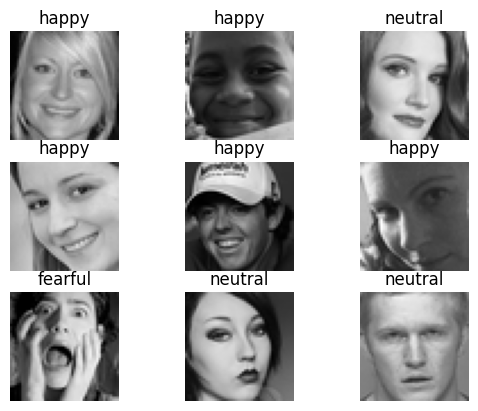

In [ ]:
plot_dataset_sample(x_train,y_train,labels)

[3995  436 4097 7215 4979 4830 3171]


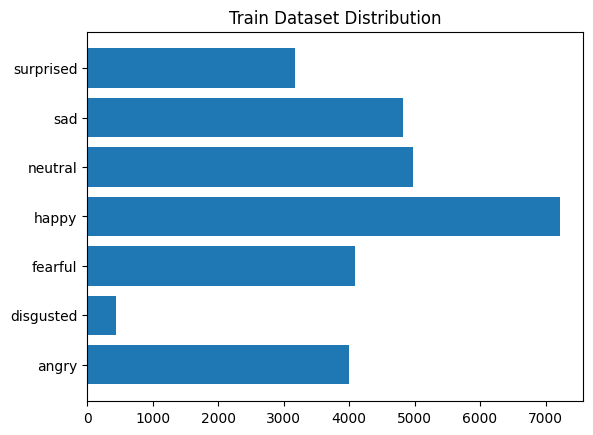

In [ ]:
counts = plot_class_distribution(y_train, labels, title="Train Dataset Distribution")
print(counts)

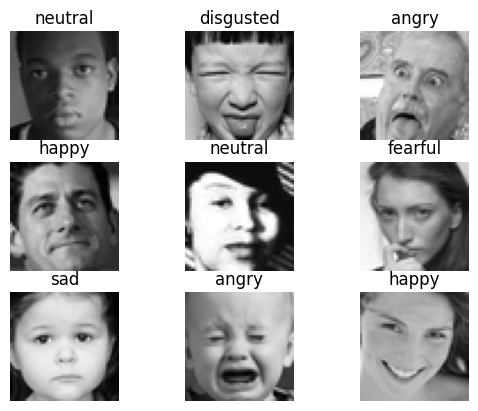

In [ ]:
plot_dataset_sample(x_test,y_test,labels)

[ 958  111 1024 1775 1233 1247  831]


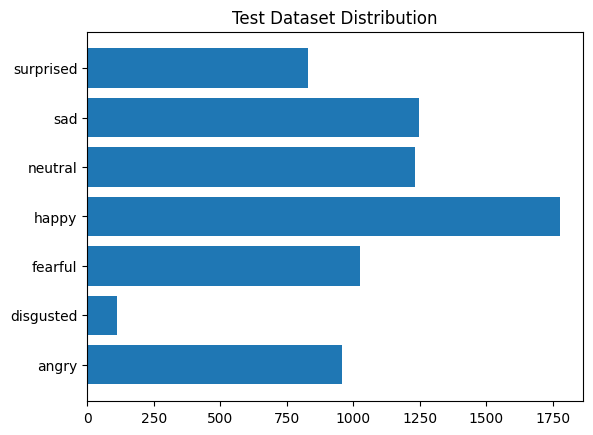

In [ ]:
counts = plot_class_distribution(y_test, labels, title="Test Dataset Distribution")
print(counts)

In [ ]:
# Convert x_train and y_train to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Create an instance of the ImageDataGenerator with desired augmentation settings
data_augmentation = ImageDataGenerator(
    rotation_range=10,  # Random rotation between -10 and 10 degrees
    width_shift_range=0.1,  # Random horizontal shift by 10% of the width
    height_shift_range=0.1,  # Random vertical shift by 10% of the height
    shear_range=0.2,  # Random shear transformation with a shear intensity of 0.2
    zoom_range=0.2,  # Random zoom between 80% and 120% of original size
    horizontal_flip=True,  # Randomly flip inputs horizontally
    vertical_flip=False,  # Do not flip inputs vertically
    fill_mode='nearest'  # Fill any newly created pixels after rotation or shift with the nearest value
)

data_augmentation2 = ImageDataGenerator(
  rotation_range=45,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest'
)

In [ ]:
# Finding the class and how big to determine the base class size for the augmentation
unique_classes, class_counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
shortest_class_idx = np.argmin(class_counts)

# Get the shortest class and its count
shortest_class = unique_classes[shortest_class_idx]
shortest_class_size = class_counts[shortest_class_idx]

# Print the shortest class and its count
print("Shortest Class:", labels[shortest_class])
print("Size of shortest Class:", shortest_class_size)

Shortest Class: disgusted
Size of shortest Class: 436


In [ ]:
# Set the desired minimum data size for each class
desired_data_size = shortest_class_size * 6

# Get the unique classes and their corresponding data sizes
unique_classes, data_sizes = np.unique(np.argmax(y_train, axis=1), return_counts=True)

# Create empty lists to store augmented samples
augmented_x = []
augmented_y = []

# Iterate over the unique classes
for class_idx, data_size in zip(unique_classes, data_sizes):
    if data_size < desired_data_size:
        # Calculate the number of additional samples needed
        num_augmentations = desired_data_size - data_size

        # Filter the samples of the current class
        class_samples = x_train[np.argmax(y_train, axis=1) == class_idx]

        # Generate augmented samples and append them
        augmented_samples = data_augmentation.flow(class_samples, batch_size=1)

        for _ in range(num_augmentations):
            augmented_sample = augmented_samples.next()[0]
            augmented_x.append(augmented_sample)
            augmented_y.append(np_utils.to_categorical(class_idx, num_classes=len(unique_classes)))

    # Append the original samples of the current class
    class_samples = x_train[np.argmax(y_train, axis=1) == class_idx]
    class_labels = y_train[np.argmax(y_train, axis=1) == class_idx]
    augmented_x.extend(class_samples)
    augmented_y.extend(class_labels)

# Convert the augmented samples to NumPy arrays
augmented_x = np.array(augmented_x)
augmented_y = np.array(augmented_y)

# Normalizing images
augmented_x = augmented_x / 255.0

In [ ]:
# #Normalizing images
# x_train = x_train / 255.0
# x_test = x_test / 255.0

# Tuning
*(Optional)*

Hyperparameter tuning for defining the network and train parameters

In [ ]:
#Defines if tuning will be used for model creation
model_tuning = False

In [ ]:
class CNNHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
      kernel = hp.Choice('kernel_size', [4,5,6])
      n_filters = hp.Choice('n_filters', [40,64,80])
      pool_size = hp.Choice('pool_size', [1,2,3])
      n_neurons = hp.Choice('n_neurons', [250,500,750])
      dropout_1 = hp.Boolean('dropout_conv')
      dropout_2 = hp.Boolean('dropout_dense')

      model = Sequential()
      INPUT_SHAPE = (48, 48, 3)
      KERNEL_SIZE = (kernel, kernel)

      model.add(Conv2D(n_filters, kernel_size=KERNEL_SIZE, activation='relu', padding='same', input_shape=INPUT_SHAPE))
      model.add(MaxPool2D(pool_size=(pool_size,pool_size))) #adição
      model.add(BatchNormalization())

      model.add(Conv2D(n_filters, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
      model.add(BatchNormalization())
      model.add(MaxPool2D(pool_size=(pool_size,pool_size)))

      for i in range(1,3):
        model.add(Conv2D(n_filters*2**i, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
        if dropout_1:
          model.add(Dropout(0.2))
        model.add(BatchNormalization())

        model.add(Conv2D(n_filters*2**i, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(pool_size,pool_size), padding='same'))

      model.add(Flatten())
      model.add(Dense(n_neurons,activation='relu'))
      if dropout_2:
        model.add(Dropout(0.2))
      model.add(Dense(len(labels),activation='softmax'))

      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

      return model

    def fit(self, hp, model, x, y, validation_data=None, **kwargs):
        return model.fit(
            x,
            y,
            batch_size=hp.Choice('batch_size', [64,128,256]),
            validation_data=validation_data,
            **kwargs)

In [ ]:
if model_tuning:
  tuner = keras_tuner.RandomSearch(
    CNNHyperModel(),
    objective='val_accuracy',
    project_name="emotion_recognition",
    overwrite=True,
    max_trials=15)

  tuner.search(
      x_train,
      y_train,
      validation_split=0.2,
      epochs=20)

  tuner.results_summary()


In [ ]:
if model_tuning:
  hypermodel = CNNHyperModel()
  best_hp = tuner.get_best_hyperparameters()[0]
  model = hypermodel.build(best_hp)
  model.summary()

# Model
Model initialization and configuration, in case of the tuning no being used



In [ ]:
if not model_tuning:
  kernel = 6
  n_filters = 40
  pool_size = 3
  n_neurons = 500

  model = Sequential()
  INPUT_SHAPE = (48, 48, 3)
  KERNEL_SIZE = (kernel, kernel)

  model.add(Conv2D(n_filters, kernel_size=KERNEL_SIZE, activation='relu', padding='same', input_shape=INPUT_SHAPE))
  model.add(BatchNormalization())

  model.add(Conv2D(n_filters, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(pool_size,pool_size)))

  for i in range(1,3):
    model.add(Conv2D(n_filters*2**i, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())

    model.add(Conv2D(n_filters*2**i, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(pool_size,pool_size), padding='same'))

  model.add(Flatten())
  model.add(Dense(n_neurons,activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(len(labels),activation='softmax'))




  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
  model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 40)        4360      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 40)       160       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 40)        57640     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 40)       160       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 40)       0         
 )                                                               
                                                        

#Training of the Model

In [ ]:
#Checks if this works
from keras import backend as K
K.clear_session()

In [ ]:
#Configure early stopping condition - no improvement in accuracy on validation set after 10 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
epochs=200
batch_size = 64
history = model.fit(
  x_train,
  y_train,
  batch_size=batch_size,
  validation_split=0.2,
  epochs=epochs,
  callbacks=[early_stop]
)


Epoch 1/200
360/360 [==============================] - 31s 39ms/step - loss: 1.9125 - accuracy: 0.2541 - val_loss: 1.6936 - val_accuracy: 0.3158
Epoch 2/200
360/360 [==============================] - 13s 36ms/step - loss: 1.5887 - accuracy: 0.3742 - val_loss: 1.5592 - val_accuracy: 0.3843
Epoch 3/200
360/360 [==============================] - 13s 37ms/step - loss: 1.4443 - accuracy: 0.4417 - val_loss: 1.3977 - val_accuracy: 0.4637
Epoch 4/200
360/360 [==============================] - 13s 36ms/step - loss: 1.3382 - accuracy: 0.4852 - val_loss: 1.3193 - val_accuracy: 0.4938
Epoch 5/200
360/360 [==============================] - 13s 37ms/step - loss: 1.2574 - accuracy: 0.5187 - val_loss: 1.2723 - val_accuracy: 0.5111
Epoch 6/200
360/360 [==============================] - 13s 37ms/step - loss: 1.1808 - accuracy: 0.5532 - val_loss: 1.2211 - val_accuracy: 0.5332
Epoch 7/200
360/360 [==============================] - 13s 37ms/step - loss: 1.1318 - accuracy: 0.5722 - val_loss: 1.2187 - val_ac

# Results
Results obtained by the trained networks

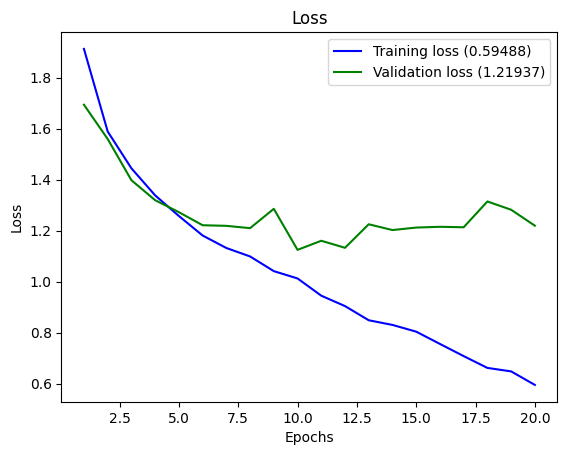

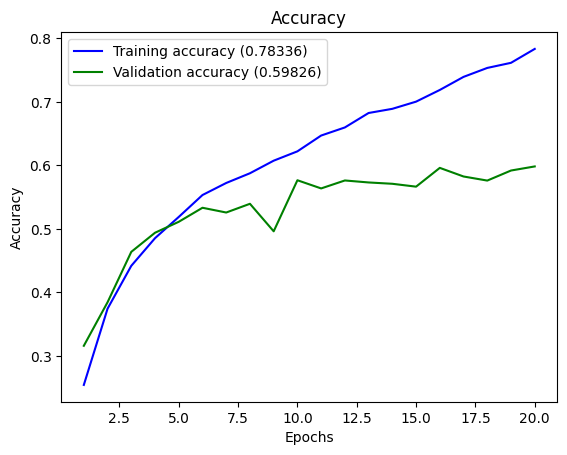

In [ ]:
plot_history(history)

In [ ]:
model.evaluate(x_test,y_test)

225/225 [==============================] - 2s 7ms/step - loss: 1.1968 - accuracy: 0.6096


[1.1968488693237305, 0.6095556616783142]

225/225 [==============================] - 2s 6ms/step


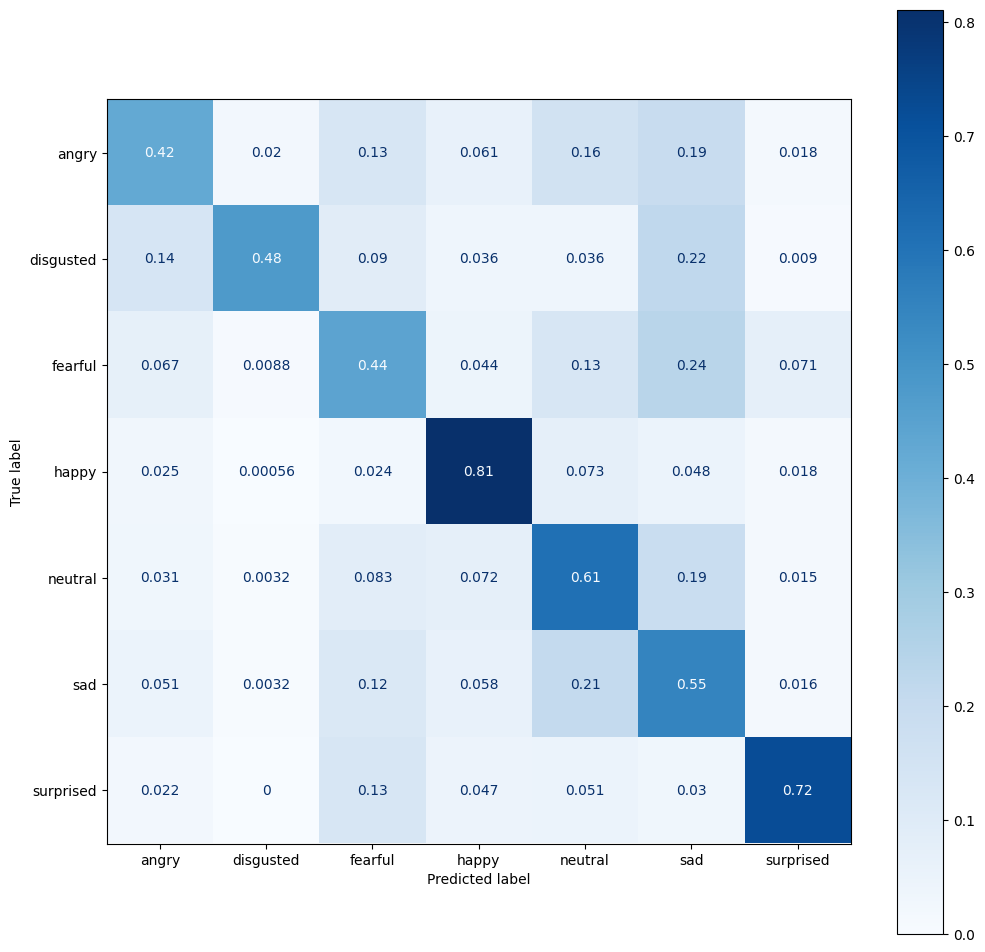

In [ ]:
#Plotting Confusion Matrix

#Obtaining CNN outputs from the test dataset
y_prediction = model.predict(x_test,verbose=1)

#Converting outputs to a 1-D array with label index
y_prediction = np.argmax(y_prediction, axis=1)
y_true = np.argmax(y_test,axis=1)

plot_confusion_matrix(y_true, y_prediction,labels)


In [ ]:
cross_validation(model,x_train,y_train,x_test,y_test,n_splits=10)

------------------------------------------------------------------------
Training for split 1
Score for fold 1: loss of 0.5213636159896851; accuracy of 87.998%
------------------------------------------------------------------------
Training for split 2
Score for fold 2: loss of 0.5202332735061646; accuracy of 90.699%
------------------------------------------------------------------------
Training for split 3
Score for fold 3: loss of 0.4917924106121063; accuracy of 89.916%
------------------------------------------------------------------------
Training for split 4
Score for fold 4: loss of 0.5513275861740112; accuracy of 90.501%
------------------------------------------------------------------------
Training for split 5
Score for fold 5: loss of 0.557006299495697; accuracy of 90.724%
------------------------------------------------------------------------
Training for split 6
Score for fold 6: loss of 0.5572665333747864; accuracy of 91.253%
-----------------------------------------